# dataset.py should contain something like this / что-то подобное должно быть в dataset.py

In [ ]:
import numpy
import torch

class DataSetIndex:
    def __init__(self, seed=0, n_items=1000, low=-10.0, high=10.0):
        valid_frac = 0.1
        test_frac = 0.5

        numpy.random.seed(seed)

        Xs = numpy.random.uniform(low=low, high=high, size=n_items)
        Ys = numpy.sin(Xs)
        Ys += numpy.random.randn(len(Xs)) * 0.1

        n_test = int(test_frac * n_items)
        n_valid = int(valid_frac * n_items)

        self.Xs = {
            'test':  Xs[:n_test],
            'valid': Xs[n_test:n_test + n_valid],
            'train': Xs[n_test + n_valid:]
        }

        self.Ys = {
            'test':  Ys[:n_test],
            'valid': Ys[n_test:n_test + n_valid],
            'train': Ys[n_test + n_valid:]
        }

        self.order = {
            'test':  numpy.arange(n_test),
            'valid': numpy.arange(n_valid),
            'train': numpy.random.permutation(len(Xs) - n_test - n_valid)
        }

    def shuffle(self):
        self.order['train'] = numpy.random.permutation(
            len(self.order['train']))



class DataSet:
    def __init__(self, ds_index, mode='train'):
        self.ds_index = ds_index
        self.mode = mode

    def __len__(self):
        return len(self.ds_index.Xs[self.mode])

    def __getitem__(self, index):
        id = self.ds_index.order[self.mode][index]
        x = [torch.FloatTensor([self.ds_index.Xs[self.mode][id]])]
        y = [torch.FloatTensor([self.ds_index.Ys[self.mode][id]])]
        return x, y, self.mode + '_' + str(id)

    def shuffle(self):
        self.ds_index.shuffle()


# model.py should contdaint something like this / что-то подобное должно быть в model.py

In [ ]:
import torch.nn as nn
import torch
from scorch.utils import OptimizerSwitch

class Network(torch.nn.Module):
    def __init__(self, n_neurons=100):
        super(Network, self).__init__()
        self.hidden = nn.Linear(1, n_neurons)
        self.out = nn.Linear(n_neurons, 1)

    def forward(self, x):
        res = x[0]
        res = self.hidden(res)
        res = torch.sigmoid(res)
        res = self.out(res)

        return [res]

class Socket:
    def __init__(self, model):
        self.model = model
        self.optimizers = [OptimizerSwitch(self.model, torch.optim.Adam,
            lr=3.0e-2)]
        self.metric_vals = {}
        self.epoch = 0
        self.iteration = 0

    def criterion(self, pred, targ):
        res = (pred[0] - targ[0]) ** 2
        return res.mean()

    def metrics(self, pred, target):
        thresholds = [0.3, 0.1, 0.03, 0.01]
        res = {}

        main = 0.0

        for thresh in thresholds:
            correct = ((pred[0] - target[0]).abs() < thresh).float().sum()
            res['acc_' + str(thresh)] = correct / float(len(target[0]))
            main += res['acc_' + str(thresh)]

        res['main'] = main / len(thresholds)
        return res

    def process_result(self, one_input, one_output, one_id):
        return (one_input, one_output)


In [1]:
%pylab inline
import torch
import numpy
import sys

Populating the interactive namespace from numpy and matplotlib


# Testing the dataset / Проверяем датасет

In [2]:
import dataset

In [3]:
ds_index = dataset.DataSetIndex(n_items=1000)

ds_train = dataset.DataSet(ds_index, mode='train')
ds_valid = dataset.DataSet(ds_index, mode='valid')
ds_test  = dataset.DataSet(ds_index, mode='test')

In [4]:
print(len(ds_train), '<- # train data')
print(len(ds_valid), '<- # valid data')
print(len(ds_test), '<- # test data')

400 <- # train data
100 <- # valid data
500 <- # test data


In [5]:
x, y, id = ds_train[0]

In [6]:
print(x[0], y[0], id)

tensor([ 8.5442]) tensor([ 0.8619]) train_121


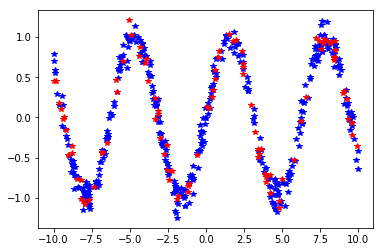

In [7]:
# Viewing the dataset
xs_train = []
ys_train = []

xs_valid = []
ys_valid = []

for x, y, id in ds_train:
    xs_train.append(x)
    ys_train.append(y)
    
for x, y, id in ds_valid:
    xs_valid.append(x)
    ys_valid.append(y)
    
plot(xs_train, ys_train, '*b')
plot(xs_valid, ys_valid, '*r')

# Testing the model script / Проверяем скрипт модели 

In [8]:
import model

net = model.Network()
socket = model.Socket(net)

In [9]:
print(x)
print(net(x))

[tensor([ 9.5905])]
[tensor([-0.5263])]


# Training the model / Тренируем модель

In [10]:
!scorch-train --model model.py --dataset dataset.py --epochs 10

Valid 0  D 0.00(0.00)  L 5.00e-01(4.64e-01)  Metrics: acc_0.3:2.10e-01 acc_0.1:8.00e-02 acc_0.03:3.00e-02 acc_0.01:1.00e-02 main:8.25e-02: 100% 13/13 [00:00<00:00, 96.81it/s]
Train 1  D 0.00(0.00)  L 7.50e-01(4.91e-01)  : 100% 50/50 [00:00<00:00, 1103.43it/s]
Valid 1  D 0.00(0.00)  L 4.87e-01(4.40e-01)  Metrics: acc_0.3:2.90e-01 acc_0.1:1.30e-01 acc_0.03:4.00e-02 acc_0.01:2.00e-02 main:1.20e-01: 100% 13/13 [00:00<00:00, 97.65it/s]
Test  : 100% 63/63 [00:02<00:00, 24.07it/s]
Train 2  D 0.00(0.00)  L 5.86e-01(4.06e-01)  : 100% 50/50 [00:00<00:00, 1351.01it/s]
Valid 2  D 0.00(0.00)  L 4.34e-01(4.65e-01)  Metrics: acc_0.3:2.40e-01 acc_0.1:7.00e-02 acc_0.03:3.00e-02 acc_0.01:2.00e-02 main:9.00e-02: 100% 13/13 [00:00<00:00, 98.37it/s]
Test  : 100% 63/63 [00:02<00:00, 23.57it/s]
Train 3  D 0.00(0.00)  L 5.43e-01(3.95e-01)  : 100% 50/50 [00:00<00:00, 1330.83it/s]
Valid 3  D 0.00(0.00)  L 4.29e-01(5.88e-01)  Metrics: acc_0.3:2.60e-01 acc_0.1:1.00e-01 acc_0.03:3.00e-02 acc_0.01:0.00e+00 main:9.7

In [11]:
!scorch-train --model model.py --dataset dataset.py --epochs 100 -cp 100_epochs

Valid 0  D 0.00(0.00)  L 5.00e-01(4.64e-01)  Metrics: acc_0.3:2.10e-01 acc_0.1:8.00e-02 acc_0.03:3.00e-02 acc_0.01:1.00e-02 main:8.25e-02: 100% 13/13 [00:00<00:00, 92.70it/s]
Train 1  D 0.00(0.00)  L 7.50e-01(4.91e-01)  : 100% 50/50 [00:00<00:00, 1050.07it/s]
Valid 1  D 0.00(0.00)  L 4.87e-01(4.40e-01)  Metrics: acc_0.3:2.90e-01 acc_0.1:1.30e-01 acc_0.03:4.00e-02 acc_0.01:2.00e-02 main:1.20e-01: 100% 13/13 [00:00<00:00, 96.02it/s]
Test  : 100% 63/63 [00:02<00:00, 23.78it/s]
Train 2  D 0.00(0.00)  L 5.86e-01(4.06e-01)  : 100% 50/50 [00:00<00:00, 1169.01it/s]
Valid 2  D 0.00(0.00)  L 4.34e-01(4.65e-01)  Metrics: acc_0.3:2.40e-01 acc_0.1:7.00e-02 acc_0.03:3.00e-02 acc_0.01:2.00e-02 main:9.00e-02: 100% 13/13 [00:00<00:00, 96.90it/s]
Test  : 100% 63/63 [00:02<00:00, 23.67it/s]
Train 3  D 0.00(0.00)  L 5.43e-01(3.95e-01)  : 100% 50/50 [00:00<00:00, 1196.48it/s]
Valid 3  D 0.00(0.00)  L 4.29e-01(5.88e-01)  Metrics: acc_0.3:2.60e-01 acc_0.1:1.00e-01 acc_0.03:3.00e-02 acc_0.01:0.00e+00 main:9.7

# Testing the model / Тестируем модель

In [12]:
!scorch-test --model model.py --dataset dataset.py --checkpoint checkpoints/10_epochs_best.pth.tar --prefix 10_epochs

{'acc_0.3': tensor(0.5800), 'acc_0.1': tensor(0.2200), 'acc_0.03': tensor(1.00000e-02 *
       7.0000), 'acc_0.01': tensor(1.00000e-02 *
       3.0000), 'main': tensor(0.2250)}
Model restored from checkpoints/10_epochs_best.pth.tar
Failed to load optimizer 0.
Test  : 100% 500/500 [00:20<00:00, 24.03it/s]


In [13]:
!scorch-test --model model.py --dataset dataset.py --checkpoint checkpoints/100_epochs_best.pth.tar --prefix 100_epochs

{'acc_0.3': tensor(0.9700), 'acc_0.1': tensor(0.5700), 'acc_0.03': tensor(0.2400), 'acc_0.01': tensor(0.1000), 'main': tensor(0.4700)}
Model restored from checkpoints/100_epochs_best.pth.tar
Failed to load optimizer 0.
Test  : 100% 500/500 [00:21<00:00, 23.74it/s]


# Result analysis / Анализируем результат

In [14]:
import os
import torch

path = './10_epochs_results/'

xs = []
ys = []

for f_name in os.listdir(path):
    f_name = os.path.join(path, f_name)
    res = torch.load(f_name)
    for id in res:
        xs.append(res[id][0])
        ys.append(res[id][1])
#     break

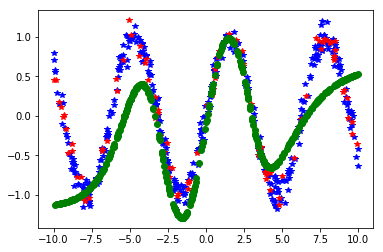

In [15]:
plot(xs_train, ys_train, '*b')
plot(xs_valid, ys_valid, '*r')
plot(xs, ys, 'og')

In [16]:
import os
import torch

path = './100_epochs_results/'

xs = []
ys = []

for f_name in os.listdir(path):
    f_name = os.path.join(path, f_name)
    res = torch.load(f_name)
    for id in res:
        xs.append(res[id][0])
        ys.append(res[id][1])
#     break

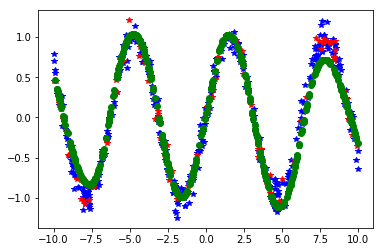

In [17]:
plot(xs_train, ys_train, '*b')
plot(xs_valid, ys_valid, '*r')
plot(xs, ys, 'og')